ref
- https://www.kaggle.com/code/shailaja4247/customer-lifetime-value-prediction (dataset)
- https://practicaldatascience.co.uk/data-science/how-to-calculate-clv-using-bgnbd-and-gamma-gamma (method-application)
- https://colab.research.google.com/drive/1yxUkWZSBJWIoxBAi7MIxvkWKNgr0NXDH#scrollTo=Zh9sP9TIBtqA (method-theory)

In [9]:
# Load the packages
# ! pip install lifetimes

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from lifetimes import BetaGeoFitter # model is based on the original Pareto/NBD model for CLV but much easier to implement
from lifetimes import GammaGammaFitter # predictions for the monetary value
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases


In [4]:
# Load data

df = pd.read_excel('online_retail_II.xlsx')
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Data preprocessing & EDA

In [7]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
df['InvoiceDate'].describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  525461
unique                  25296
top       2010-12-06 16:57:00
freq                      675
first     2009-12-01 07:45:00
last      2010-12-09 20:01:00
Name: InvoiceDate, dtype: object

In [10]:
# Calculate recency, frequency, and monetary 
# Recency : time between first and last transaction
# Frequency (repeat) : the number of purchases beyond the initial one
# T : time between first purchase and end of calibration period 
# monetary value : all the transactions value in the training periods 

df['revenue'] = df.Quantity*df.Price

df_rfmt = summary_data_from_transaction_data(df, 
                                             'Customer ID', 
                                             'InvoiceDate', 
                                             'revenue',
                                             observation_period_end='2010-12-09')

df_rfmt.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,9.0,294.0,360.0,-17.186667
12347.0,1.0,37.0,39.0,711.790000
12348.0,0.0,0.0,73.0,0.000000
12349.0,3.0,328.0,370.0,890.380000
12351.0,0.0,0.0,10.0,0.000000


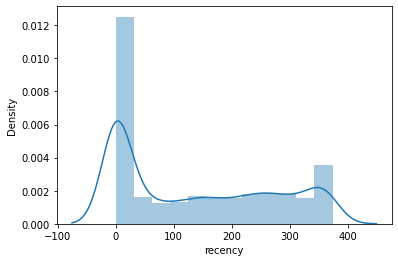

In [13]:
sns.distplot(df_rfmt['recency'])
plt.show()

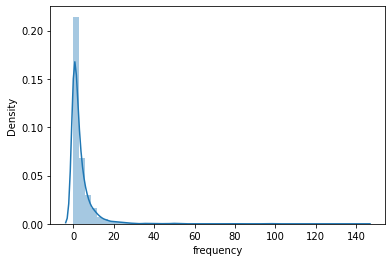

In [14]:
sns.distplot(df_rfmt['frequency'])
plt.show()

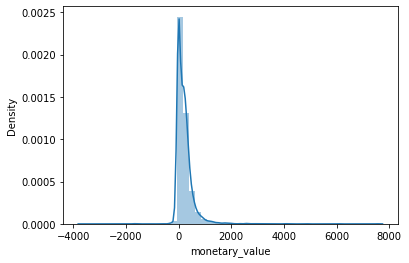

In [15]:
sns.distplot(df_rfmt['monetary_value'])
plt.show()

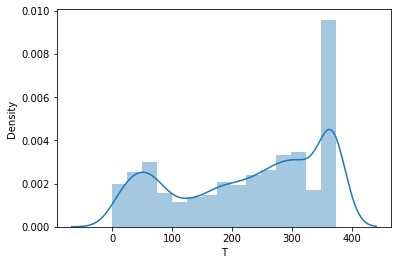

In [16]:
sns.distplot(df_rfmt['T'])
plt.show()

# BG/NBD Model 

In [17]:
# Fit the BG/NBD model

bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt['frequency'], df_rfmt['recency'], df_rfmt['T'])
bgf.summary


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.860759,0.026544,0.808734,0.912784
alpha,56.190242,2.078990,52.115422,60.265063
a,0.040686,0.015445,0.010414,0.070959
b,1.925118,1.149928,-0.328741,4.178977


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

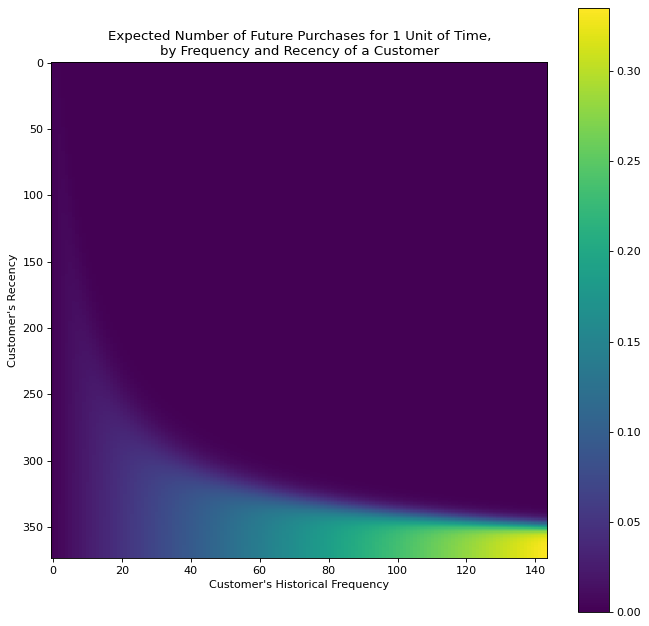

In [18]:
# Plot the recency and frequency of customers

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

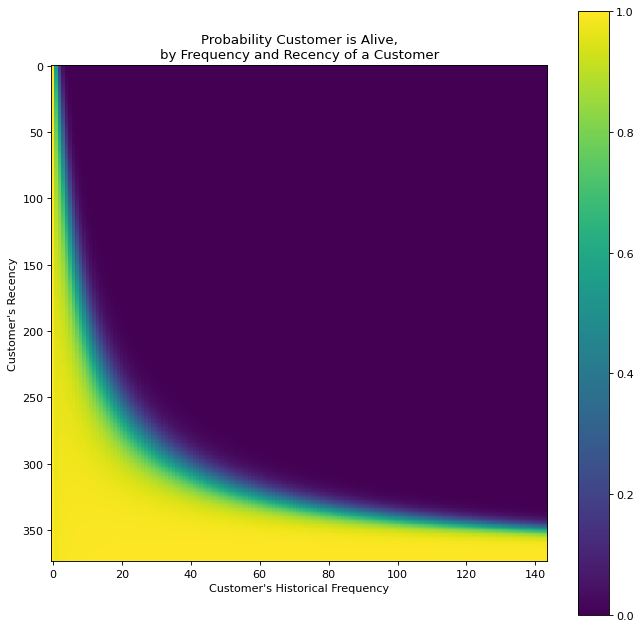

In [19]:
# Plot the probability that each customer is alive

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plot_probability_alive_matrix(bgf)


In [20]:
# Predict the number of orders each customer will make during a time period

t = 90
df_rfmt['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                         df_rfmt['frequency'], 
                                                                                         df_rfmt['recency'], 
                                                                                         df_rfmt['T'])

<function matplotlib.pyplot.show(close=None, block=None)>

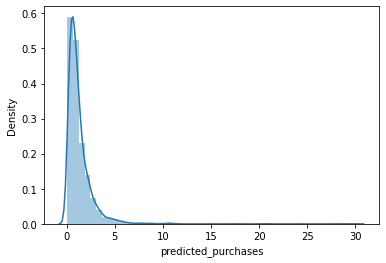

In [21]:
sns.distplot(df_rfmt['predicted_purchases'])
plt.show

## Comparisons Between Model Predictions and Training Set

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

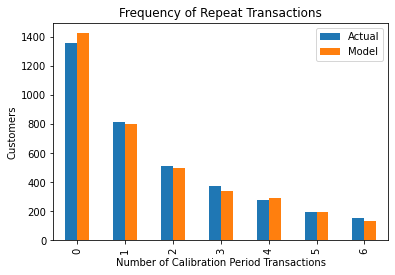

In [22]:
# Compare the model’s predictions to the actual data

plot_period_transactions(bgf)


## Comparisons Between Predictions and the Holdout (Validation) Set 

In [24]:
# Using a holdout group

summary_cal_holdout = calibration_and_holdout_data(df, 
                                                   'Customer ID', 
                                                   'InvoiceDate',
                                                    calibration_period_end='2010-09-01',
                                                    observation_period_end='2010-12-09')

summary_cal_holdout.sort_values(by='frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
14911.0,88.0,273.0,274.0,54.0,99.0
12748.0,56.0,254.0,271.0,41.0,99.0
15311.0,81.0,269.0,274.0,32.0,99.0
14156.0,68.0,266.0,274.0,30.0,99.0
14606.0,66.0,263.0,272.0,29.0,99.0


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

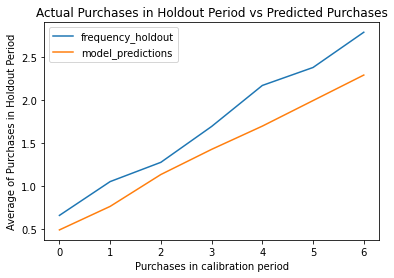

In [25]:
# Re-fit the model on the calibration period

bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

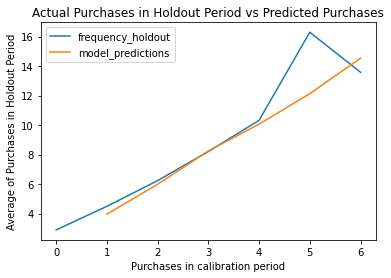

In [51]:
# Using a longer holdout period
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

summary_cal_holdout = calibration_and_holdout_data(df, 
                                                   'Customer ID', 
                                                   'InvoiceDate',
                                                    calibration_period_end='2010-03-01',
                                                    observation_period_end='2010-12-09')

bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])


plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)


In [27]:
# Get predictions for a specific customer

t = 365
individual = df_rfmt.iloc[1]
bgf.predict(t, 
            individual['frequency'], 
            individual['recency'], 
            individual['T'])

1.2341298281235369

In [53]:
# Plot customer probability history

example_customer_orders = df.loc[df['Customer ID'] == 12346]
example_customer_orders

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,revenue
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,12346.0,United Kingdom,45.00
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.50,12346.0,United Kingdom,22.50
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.50,12346.0,United Kingdom,22.50
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.50,12346.0,United Kingdom,22.50
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.00,12346.0,United Kingdom,1.00
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0,United Kingdom,22.50
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0,United Kingdom,22.50
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.50,12346.0,United Kingdom,22.50
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.50,12346.0,United Kingdom,22.50
71080,C495800,ADJUST,Adjustment by john on 26/01/2010 17,-1,2010-01-26 17:27:00,103.50,12346.0,United Kingdom,-103.50


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

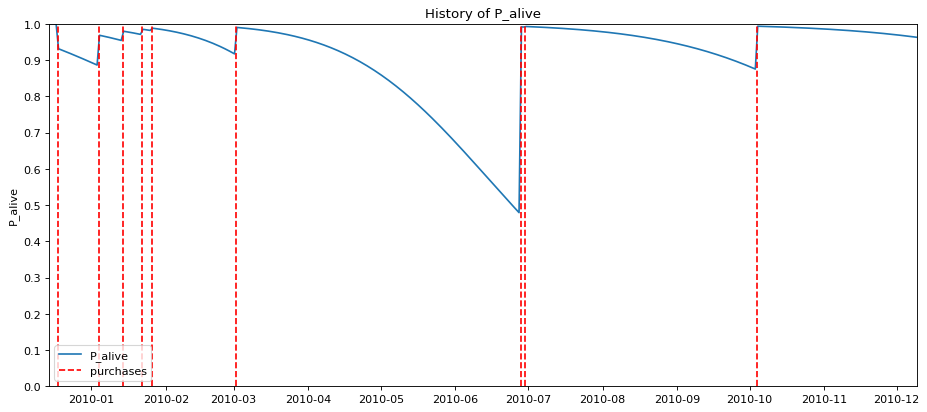

In [56]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 360
plot_history_alive(bgf, days_since_birth, example_customer_orders, 'InvoiceDate')

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

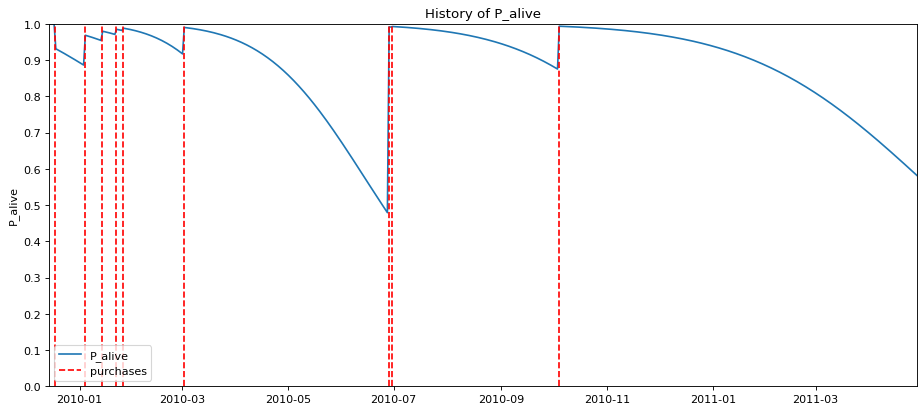

In [63]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 500
plot_history_alive(bgf, days_since_birth, example_customer_orders, 'InvoiceDate')

# Gamma-Gamma Model on the monetary value

In [36]:
# Predicting customer lifetime value

returning_customers = df_rfmt[ (df_rfmt['frequency'] > 0) & (df_rfmt['monetary_value'] > 0)]
returning_customers.sort_values(by='monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value,predicted_purchases
Customer ID,,,,,
18102.0,45.0,373.0,373.0,7544.233111,9.570152
13902.0,5.0,99.0,366.0,6085.692000,0.363688
14646.0,49.0,363.0,372.0,4860.041020,10.413831
17940.0,5.0,291.0,371.0,4119.288000,1.202041
14091.0,1.0,44.0,333.0,4010.080000,0.338990


In [37]:
returning_customers[['monetary_value', 'frequency']].corr()


,monetary_value,frequency
monetary_value,1.00000,0.17365
frequency,0.17365,1.00000


In [38]:
# Fit the Gamma-Gamma model

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2819 subjects, p: 1.53, q: 3.67, v: 601.28>

In [39]:
# Predict average order value

predicted_monetary = ggf.conditional_expected_average_profit(
        returning_customers['frequency'],
        returning_customers['monetary_value'])


In [40]:
aov_df = pd.DataFrame(predicted_monetary,columns = ['aov'])
aov_df = aov_df.sort_values(by='aov', ascending=False)

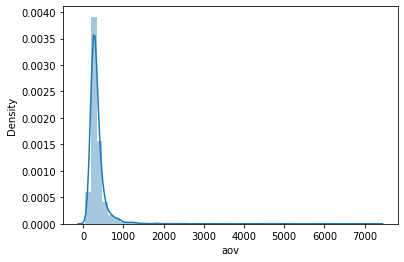

In [41]:
sns.distplot(aov_df['aov'])
plt.show()

In [42]:
# Segment customers by their AOV

aov_df['aov_bin'] = pd.qcut(aov_df['aov'], q=5, labels=[1, 2, 3, 4, 5])
aov_df = aov_df.reset_index()

In [43]:
aov_df.groupby('aov_bin').agg(count=('Customer ID', 'count'),
                              min_aov=('aov', min),
                              max_aov=('aov', max),
                              std_aov=('aov', 'std'),    
                              aov=('aov', 'mean')).sort_values(by='aov')

,count,min_aov,max_aov,std_aov,aov
aov_bin,,,,,
1,564,44.095491,227.683168,29.984542,188.212689
2,564,227.769321,269.735997,11.768985,249.254377
3,563,269.781852,320.673328,14.897779,292.605533
4,564,320.704856,402.856464,24.131793,354.702200
5,564,402.925618,7275.082241,503.767844,657.127407


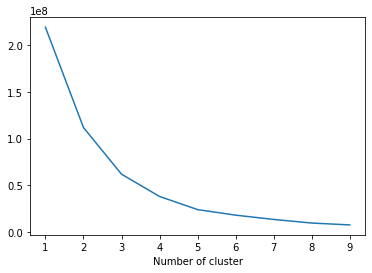

In [50]:
# Applying K-means clustering

from sklearn.cluster import KMeans

sse={} # error
aov_clusters = aov_df[['aov']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(aov_clusters)
    aov_clusters["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [44]:

kmeans = KMeans(n_clusters=5)
kmeans.fit(aov_clusters)

aov_clusters = aov_clusters.assign(cluster=kmeans.labels_)
aov_clusters.groupby('cluster')['aov'].mean().sort_values(ascending=False).to_frame()

,aov
cluster,
3,5526.110545
1,2284.782451
2,897.836511
4,441.990158
0,255.399911


# Predicting Customer Lifetime Value

CLV is obtained by 
$$CLV(t,t+dt) = E(M)~\times~ E[Y(dt)~|~\lambda, \mu, x, t_x, T] $$

In [45]:
bgf.fit(returning_customers['frequency'], 
        returning_customers['recency'], 
        returning_customers['T'])

<lifetimes.BetaGeoFitter: fitted with 2819 subjects, a: 0.05, alpha: 86.64, b: 2.44, r: 1.83>

In [46]:
preds = ggf.customer_lifetime_value( bgf,
                                    returning_customers['frequency'],
                                    returning_customers['recency'],
                                    returning_customers['T'],
                                    returning_customers['monetary_value'],
                                    time = 12,
                                    discount_rate = 0.01
)

In [48]:
preds = preds.to_frame().reset_index()

preds.sort_values(by='clv', ascending=False).head()


,Customer ID,clv
2755,18102.0,245897.537033
1084,14646.0,172666.555419
833,14156.0,131875.262155
1212,14911.0,99407.391486
608,13694.0,91713.210005


In [49]:
preds.sort_values(by='clv', ascending=False).tail()


,Customer ID,clv
1618,15794.0,155.850951
1514,15577.0,153.072640
2453,17477.0,118.565071
2728,18051.0,95.785508
488,13457.0,87.614243
